# Playground to understand how to run 3D Kirchoff mig of Volve data

**Author: M.Ravasi**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.interpolate import RegularGridInterpolator
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from segyshot import SegyShot
from visual import explode_volume

## Parameters

In [2]:
# Geometry
#ishotin, ishotend = 5500, 5540 # supersmall
#ishotin, ishotend = 5370, 5670 # 2d line
#ishotin, ishotend = 2880, 6715 # small
#ishotin, ishotend = 3080, 9596 # large
ishotin, ishotend = 2880, 10080 # full (within velocity grid)

#ivxmax = 22 # small
ivxmax = 32 # large

## Data loading

In [3]:
velfilepath = '/home/ravasim/Data/Volve/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
filepath = '/home/ravasim/Data/Volve/'

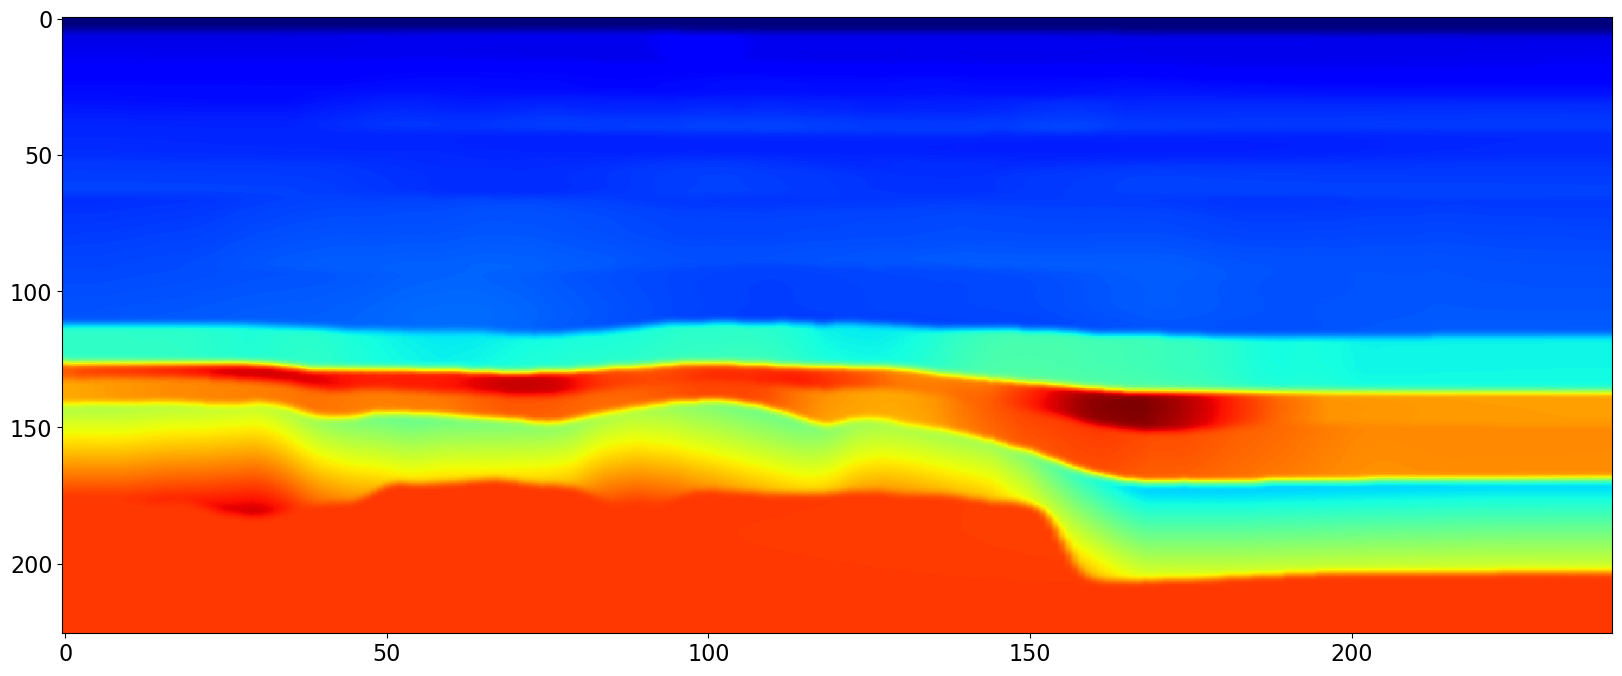

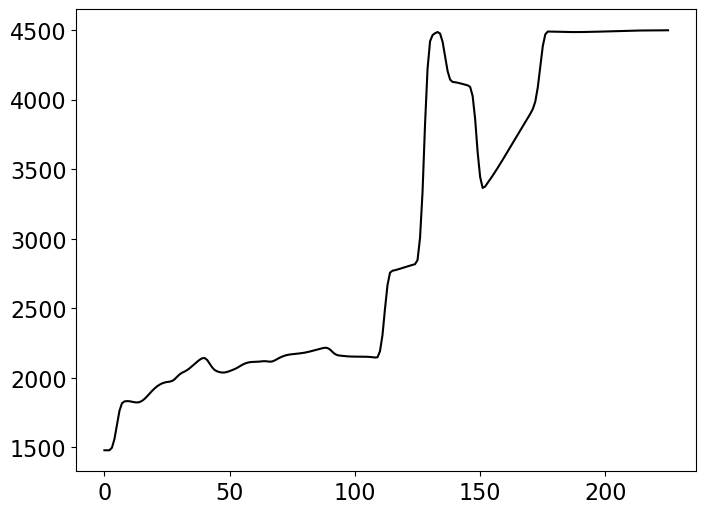

In [4]:
fvmod = segyio.open(velfilepath)
vmod = segyio.cube(velfilepath)
ilvel, xlvel, zvel = fvmod.ilines, fvmod.xlines, fvmod.samples

ilsvel, xlsvel = fvmod.attributes(segyio.TraceField.INLINE_3D)[:], fvmod.attributes(segyio.TraceField.CROSSLINE_3D)[:]

scvel = fvmod.header[0][segyio.TraceField.SourceGroupScalar]
if (scvel<0):
    scvel=1./abs(scvel)
xvel, yvel = scvel * fvmod.attributes(segyio.TraceField.CDP_X)[:] , scvel * fvmod.attributes(segyio.TraceField.CDP_Y)[:]

plt.figure(figsize=(20, 8))
plt.imshow(vmod[50].T, cmap='jet')
plt.axis('tight');

plt.figure()
plt.plot(vmod[50, 120], 'k');

In [5]:
inputfile = os.path.join(filepath, 'ST10010_1150780_40203.sgy')
f = segyio.open(inputfile, ignore_geometry=True)

## Data and velocity model cropping for imaging

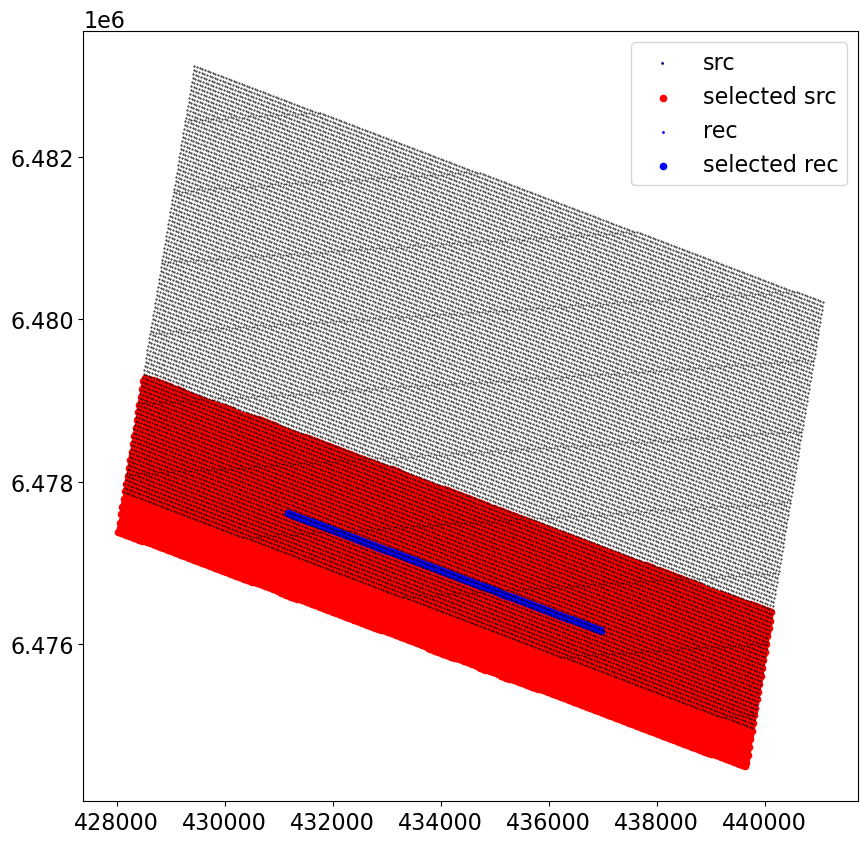

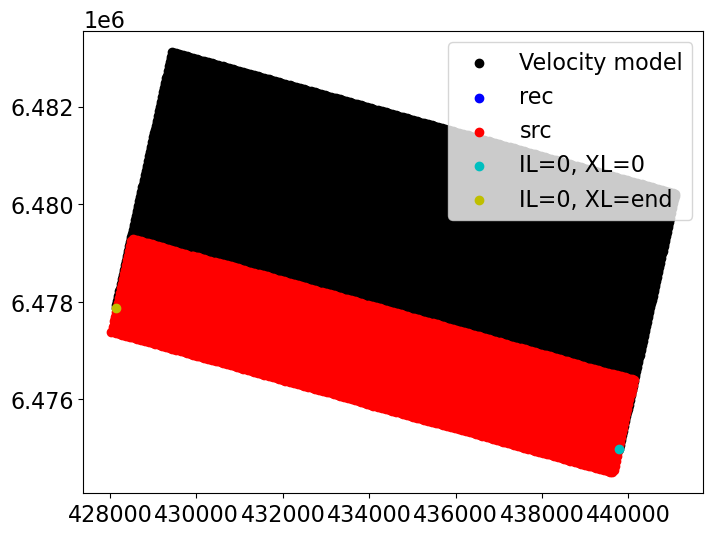

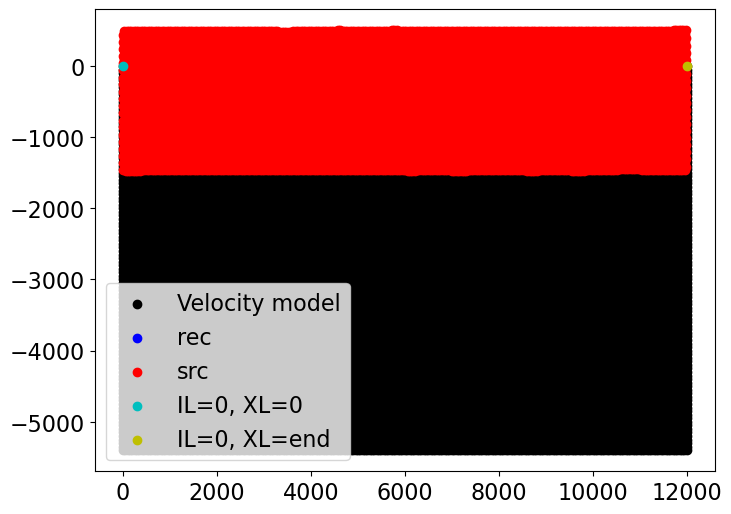

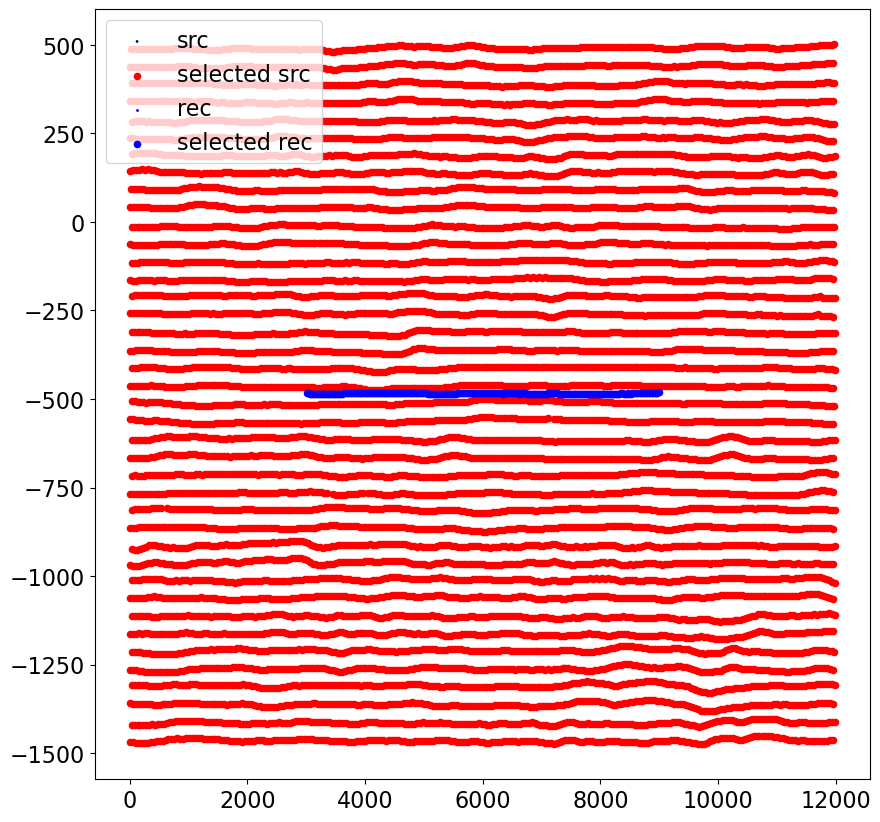

In [6]:
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.showgeometry()
plt.scatter(xvel, yvel, c='k', s=.2)

_,_,_,_, (xvel_local, yvel_local) = \
    sg.rotategeometry(velfile=velfilepath, plotflag=1)
sg.showgeometry(local=True)

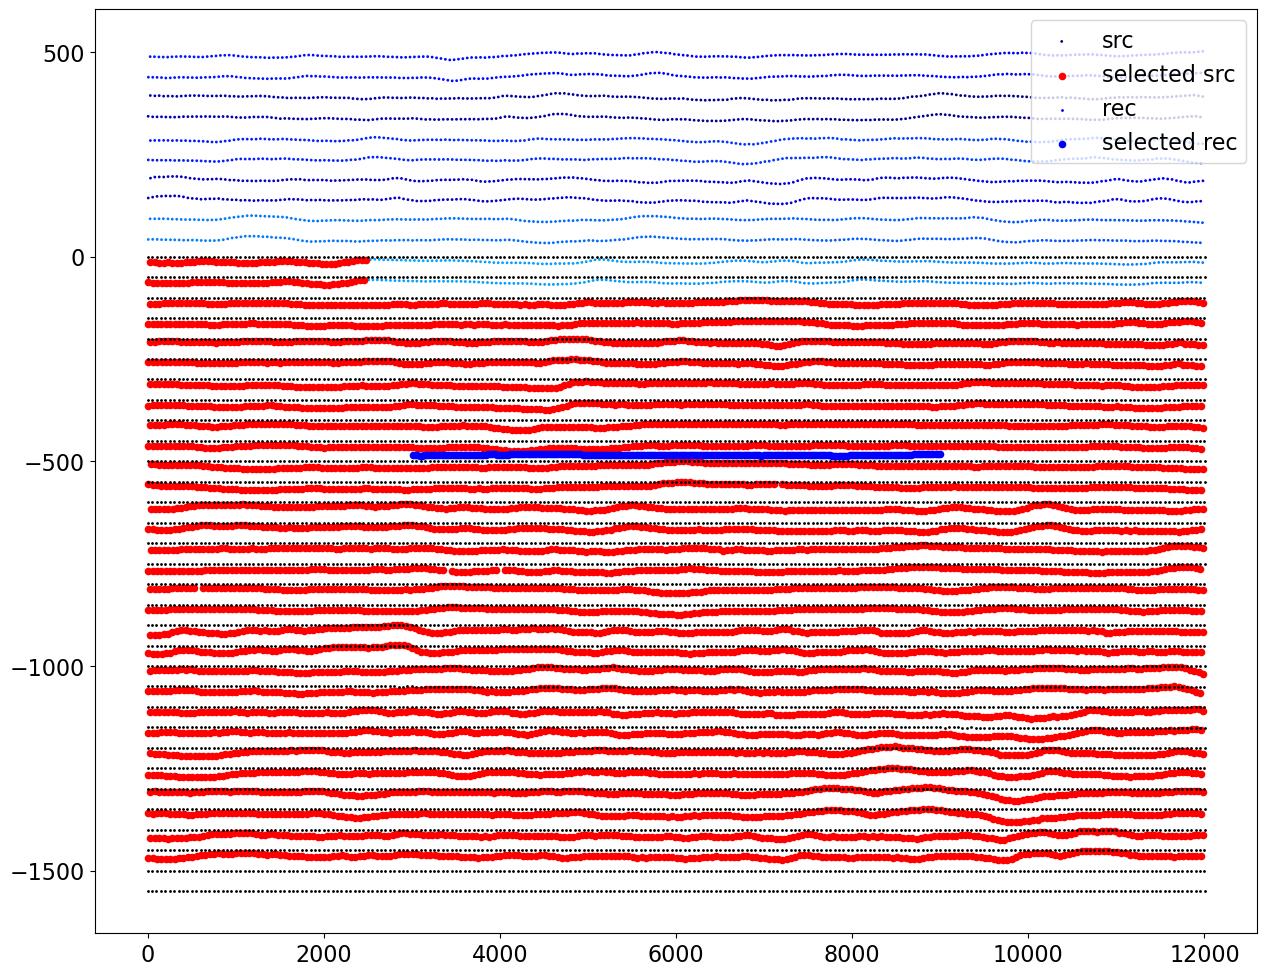

In [20]:
sg.resetsrcs()
sg.selectsrcs(ishotin, ishotend, plotflag=False)
sg.showgeometry(local=True, figsize=(15, 12))

# Extract only useful part of velocity model
xvel_localgrid = xvel_local.reshape(vmod.shape[:2])[:ivxmax]
yvel_localgrid = yvel_local.reshape(vmod.shape[:2])[:ivxmax]
vel_local = vmod[:ivxmax]

plt.scatter(xvel_localgrid.ravel(), yvel_localgrid.ravel(), c='k', s=1);
# plt.scatter(xvel_localgrid.ravel(), yvel_localgrid.ravel(), c=vel_local[:, :, 150].ravel(), s=7, cmap='jet')

In [8]:
sg.nrec

240

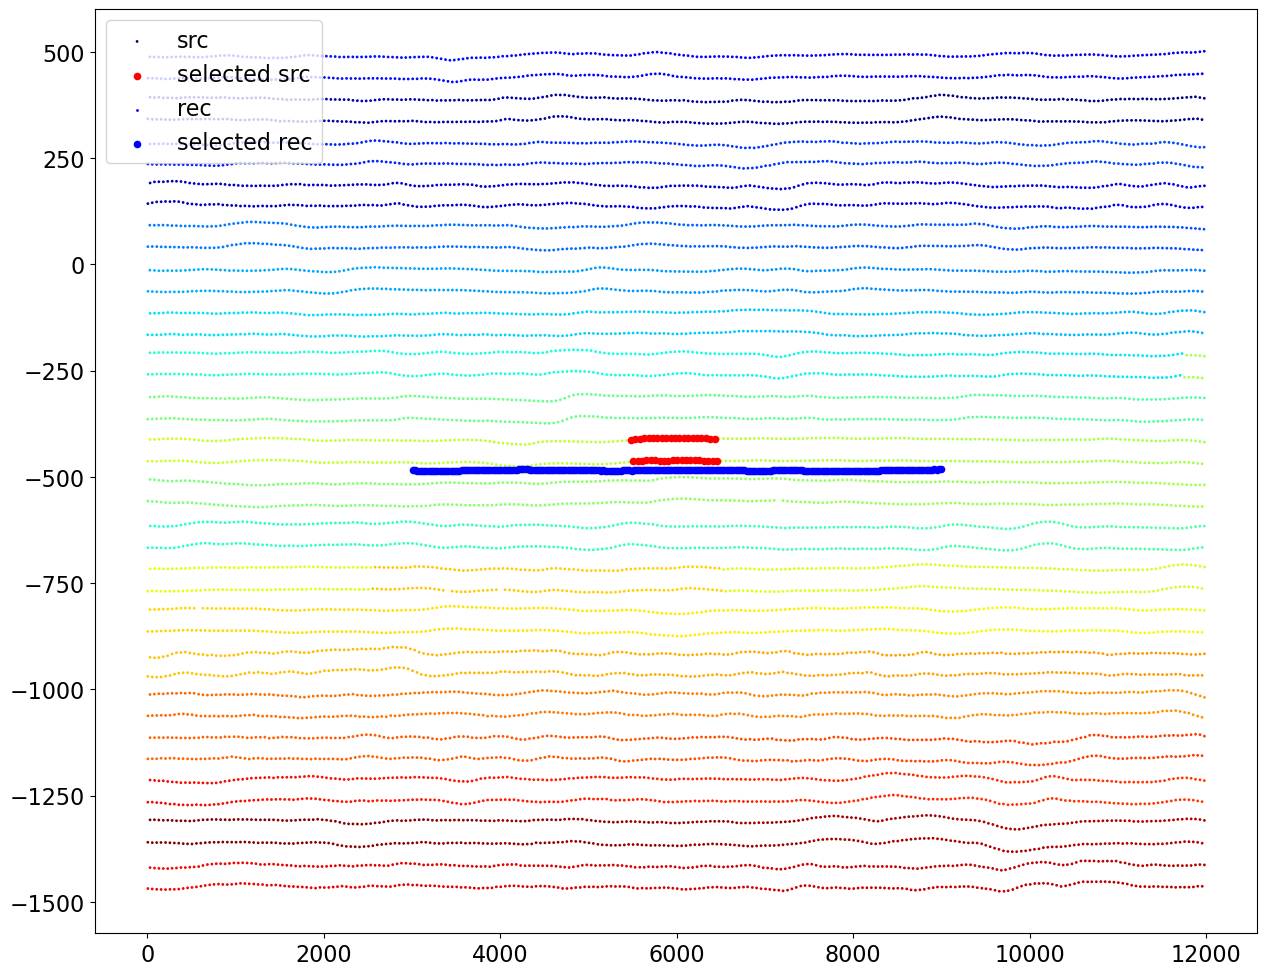

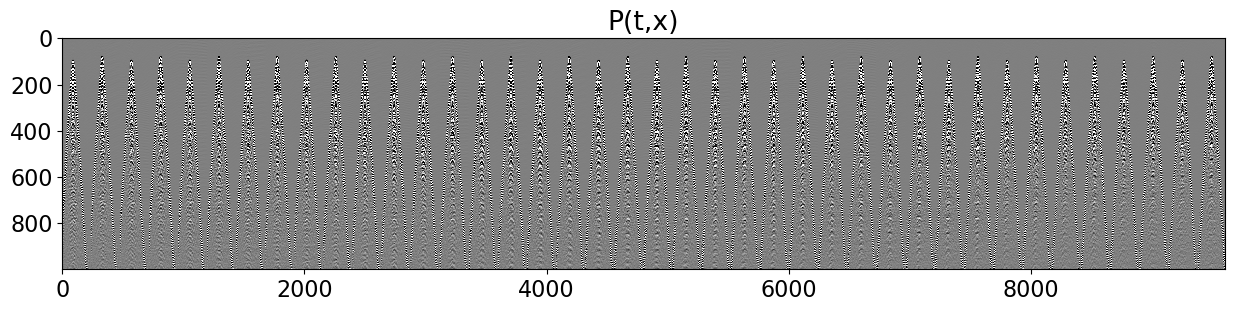

In [20]:
sg.resetsrcs()
sg.selectsrcs(5500, 5540, plotflag=False)
sg.showgeometry(local=True, figsize=(15, 12))
sg.resetsrcs()

shots = np.concatenate([sg.get_shotgather(ishot)['P'][np.newaxis, :, :1000] for ishot in range(3560, 3600)])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.imshow(shots.reshape(shots.shape[0]*shots.shape[1], -1).T, cmap='gray', vmin=-1e5, vmax=1e5)
ax.set_title('P(t,x)')
ax.axis('tight');

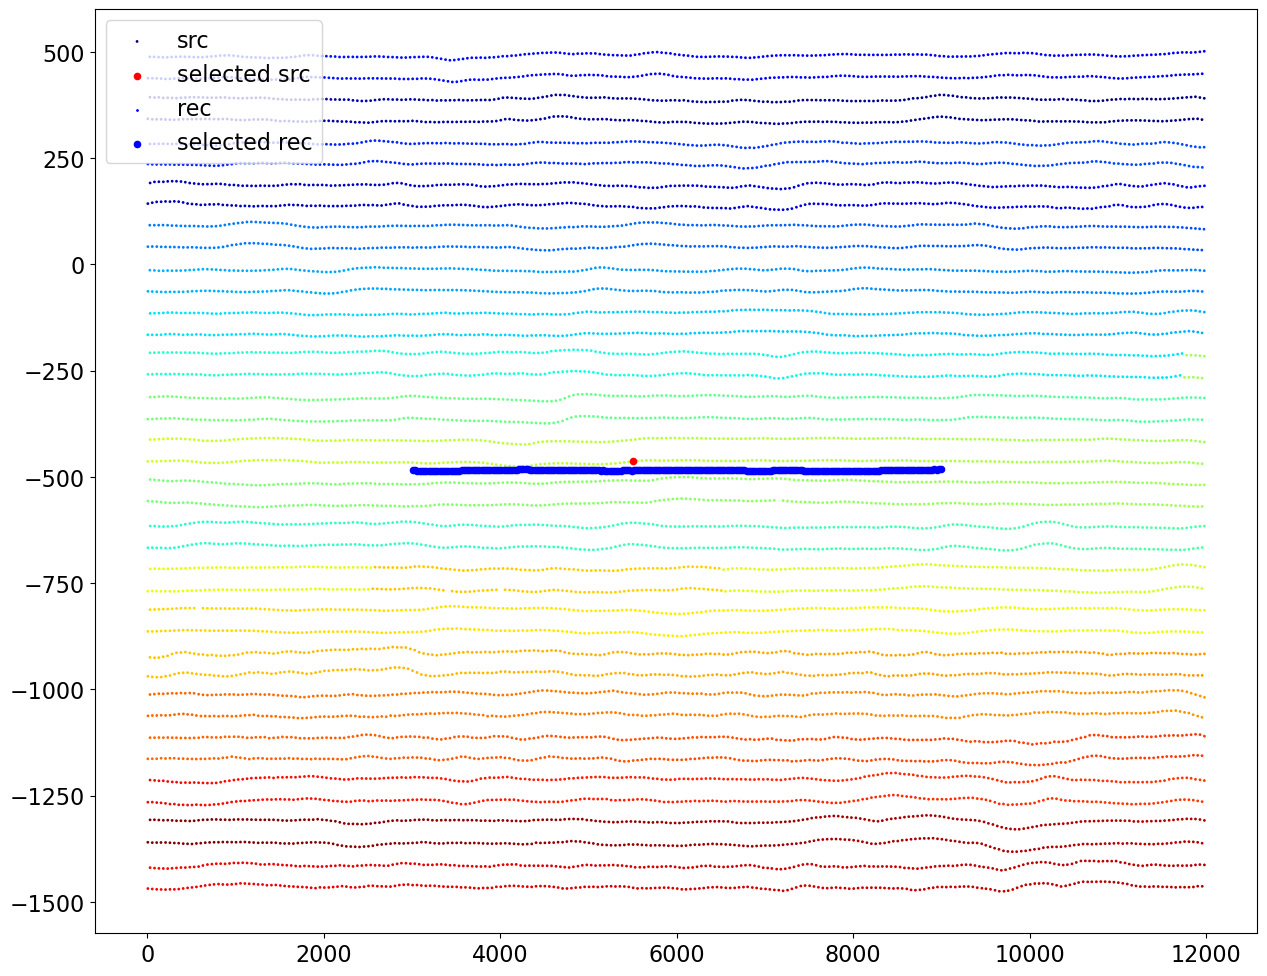

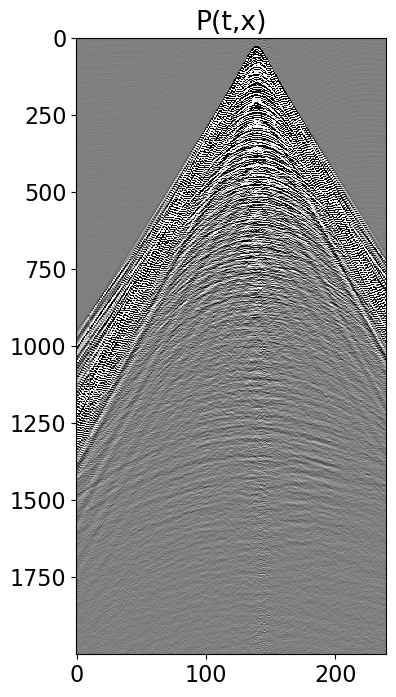

In [21]:
sg.resetsrcs()
sg.selectsrcs(5538, 5538+1, plotflag=False)
sg.showgeometry(local=True, figsize=(15, 12))

shot = sg.get_shotgather(5538)

fig, ax = plt.subplots(1, 1, figsize=(4, 8))
ax.imshow(shot['P'][:, :2000].T, cmap='gray', vmin=-1e5, vmax=1e5)
ax.set_title('P(t,x)')
ax.axis('tight');

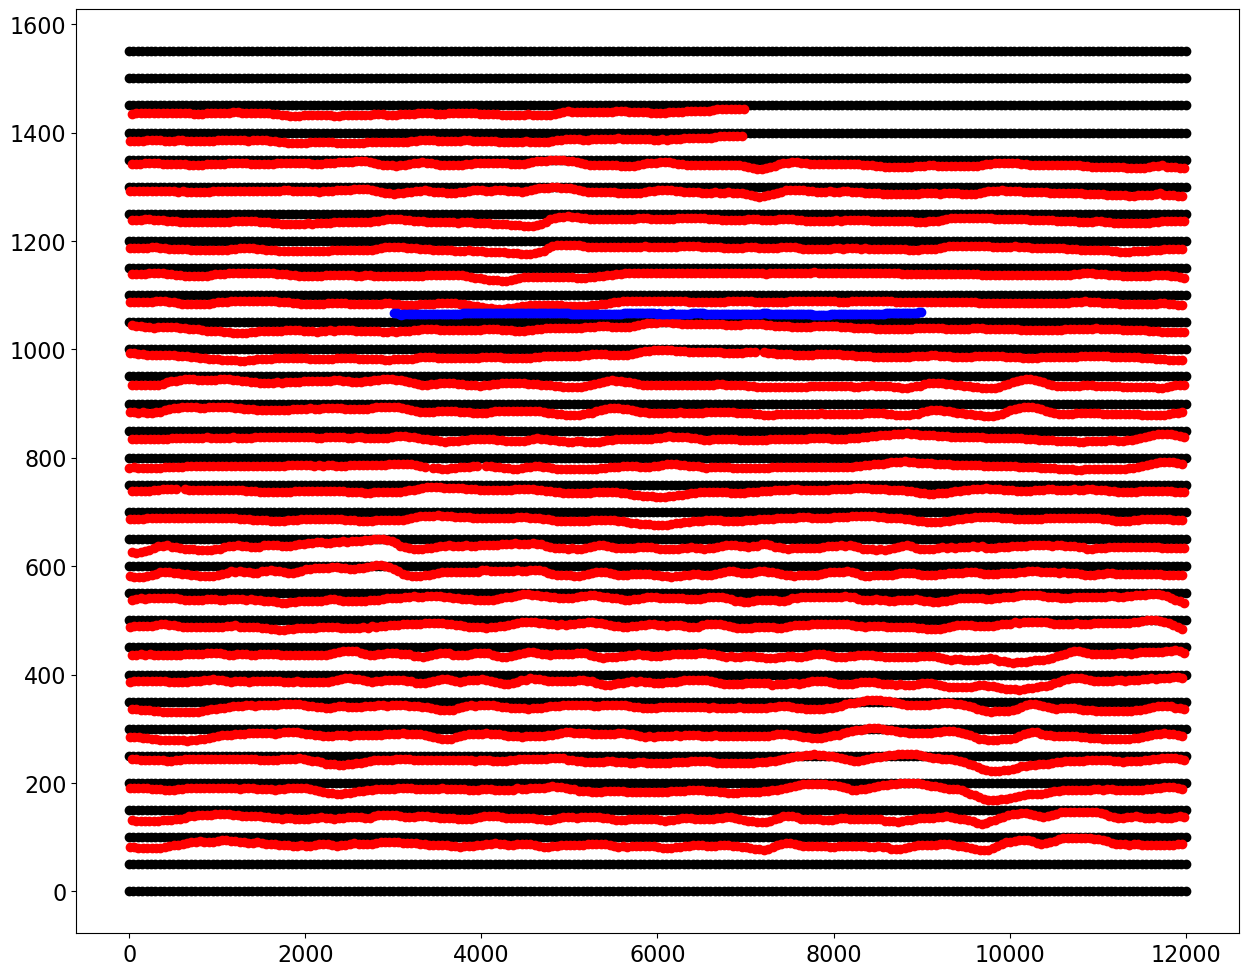

In [22]:
# Local grid
nx, ny = xvel_localgrid.T.shape
nz = len(zvel)
x0 = xvel_localgrid.min()
y0 = yvel_localgrid.min()

dx = np.round(np.mean(np.abs(np.diff(xvel_localgrid[0]))))
dy = np.round(np.mean(np.abs(np.diff(yvel_localgrid[:, 0]))))

xvel_local = np.arange(nx) * dx
yvel_local = np.arange(ny) * dy

xvel_localgrid, yvel_localgrid = np.meshgrid(xvel_local, yvel_local, indexing='ij')

sg.resetsrcs()
sg.selectsrcs(ishotin, ishotend, plotflag=False)

srcx_local = sg.srcx_local[sg.selected_src] - x0
srcy_local = sg.srcy_local[sg.selected_src] - y0
srcz_local = sg.srcz[sg.selected_src]

recx_local = sg.recx_local - x0
recy_local = sg.recy_local - y0
recz_local = sg.recz

ns, nr = srcx_local.size, recx_local.size

plt.figure(figsize=(15, 12))
plt.scatter(xvel_localgrid.ravel(), yvel_localgrid.ravel(), color='k')
plt.scatter(srcx_local, srcy_local, color='r')
plt.scatter(recx_local, recy_local, color='b');

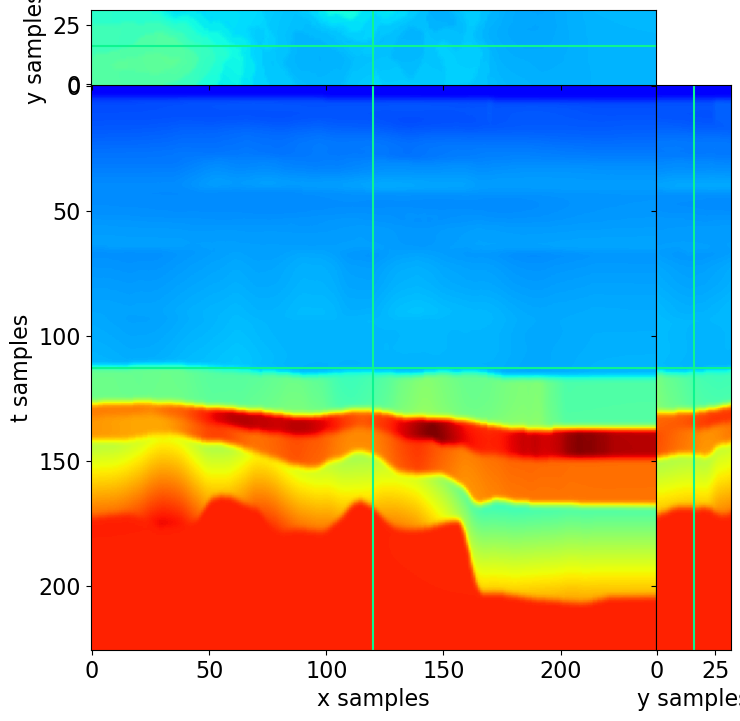

In [23]:
explode_volume(vel_local.transpose(2, 1, 0), cmap='jet', clipval=(1000, 5000));

## 3d Kirchhoff

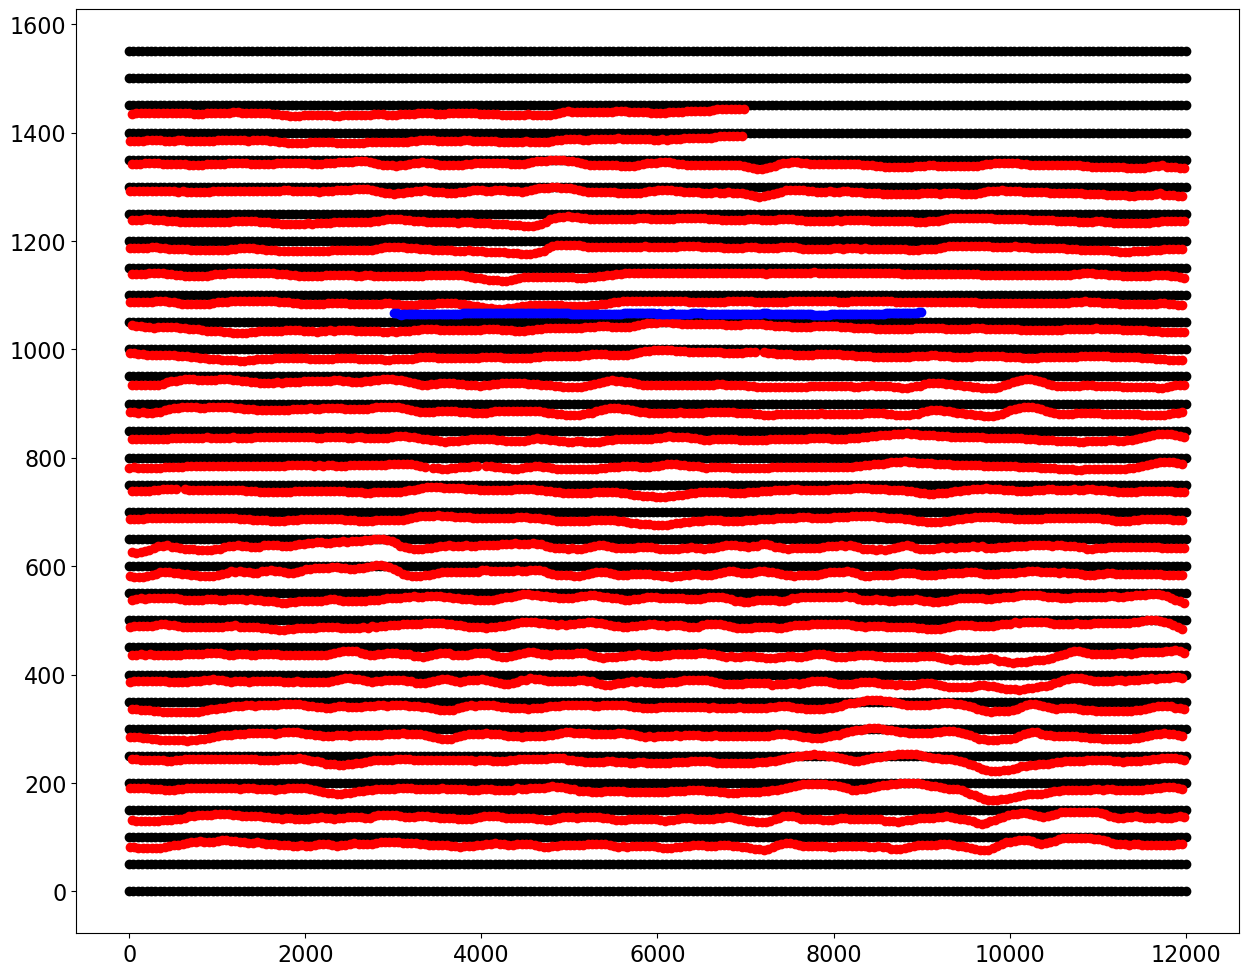

In [24]:
sg.resetsrcs()
sg.selectsrcs(ishotin, ishotend, jump=1, plotflag=False)

srcx_local = sg.srcx_local[sg.selected_src] - x0
srcy_local = sg.srcy_local[sg.selected_src] - y0
srcz_local = sg.srcz[sg.selected_src]

recx_local = sg.recx_local - x0
recy_local = sg.recy_local - y0
recz_local = sg.recz

src_local = np.vstack([srcx_local, srcz_local])
rec_local = np.vstack([recx_local, recz_local])

ns, nr = srcx_local.size, recx_local.size

plt.figure(figsize=(15, 12))
plt.scatter(xvel_localgrid.ravel(), yvel_localgrid.ravel(), color='k')
plt.scatter(srcx_local, srcy_local, color='r')
plt.scatter(recx_local, recy_local, color='b');

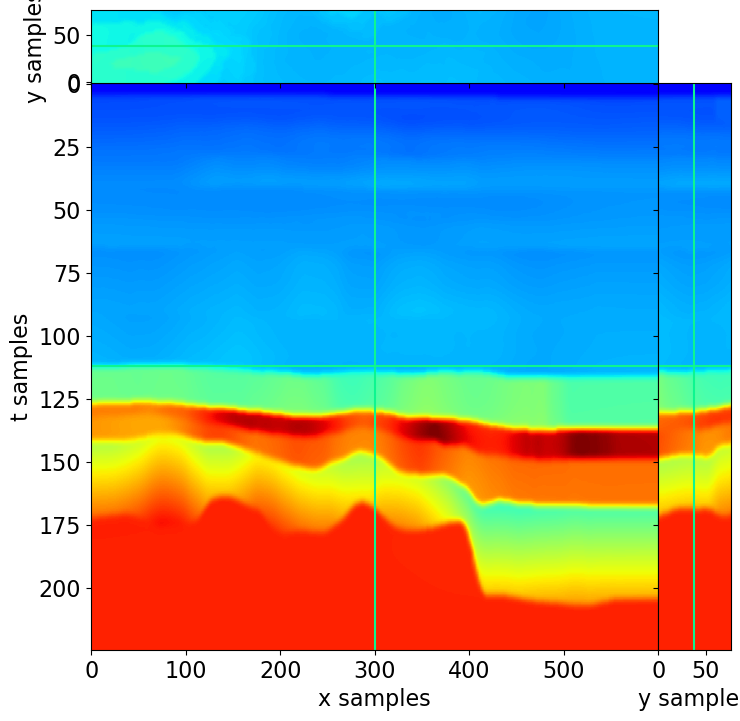

In [25]:
# Interpolate velocity model
dy3d, dx3d, dz3d = 20, 20, 20
ny3d, nx3d, nz3d = int(yvel_local[-1]//dy3d), int(xvel_local[-1]//dx3d), int(zvel[-1]//dz3d)

yvel_local3d = np.arange(ny3d) * dy3d
xvel_local3d = np.arange(nx3d) * dx3d
zvel_local3d = np.arange(nz3d) * dz3d

Y3d, X3d, Z3d = np.meshgrid(yvel_local3d, xvel_local3d, zvel_local3d, indexing='ij')
YXZ3d = np.vstack((Y3d.ravel(), X3d.ravel(), Z3d.ravel())).T

vel_interp3d = np.zeros(ny3d * nx3d * nz3d, dtype=np.float32)
interpolator = RegularGridInterpolator((yvel_local, xvel_local, zvel), vel_local, bounds_error=False, fill_value=0)
for i in range(0, ny3d*nx3d*nz3d, nx3d*nz3d):
    vel_interp3d[i:i+nx3d*nz3d] = interpolator(YXZ3d[i:i+nx3d*nz3d]).astype(np.float32)
vel_interp3d = vel_interp3d.reshape(ny3d, nx3d, nz3d)

explode_volume(vel_interp3d.transpose(2, 1, 0), cmap='jet', clipval=(1000, 5000));

That's it.. we have learned how to set things up, now let's run the imaging process in parallel!

## Visualize images

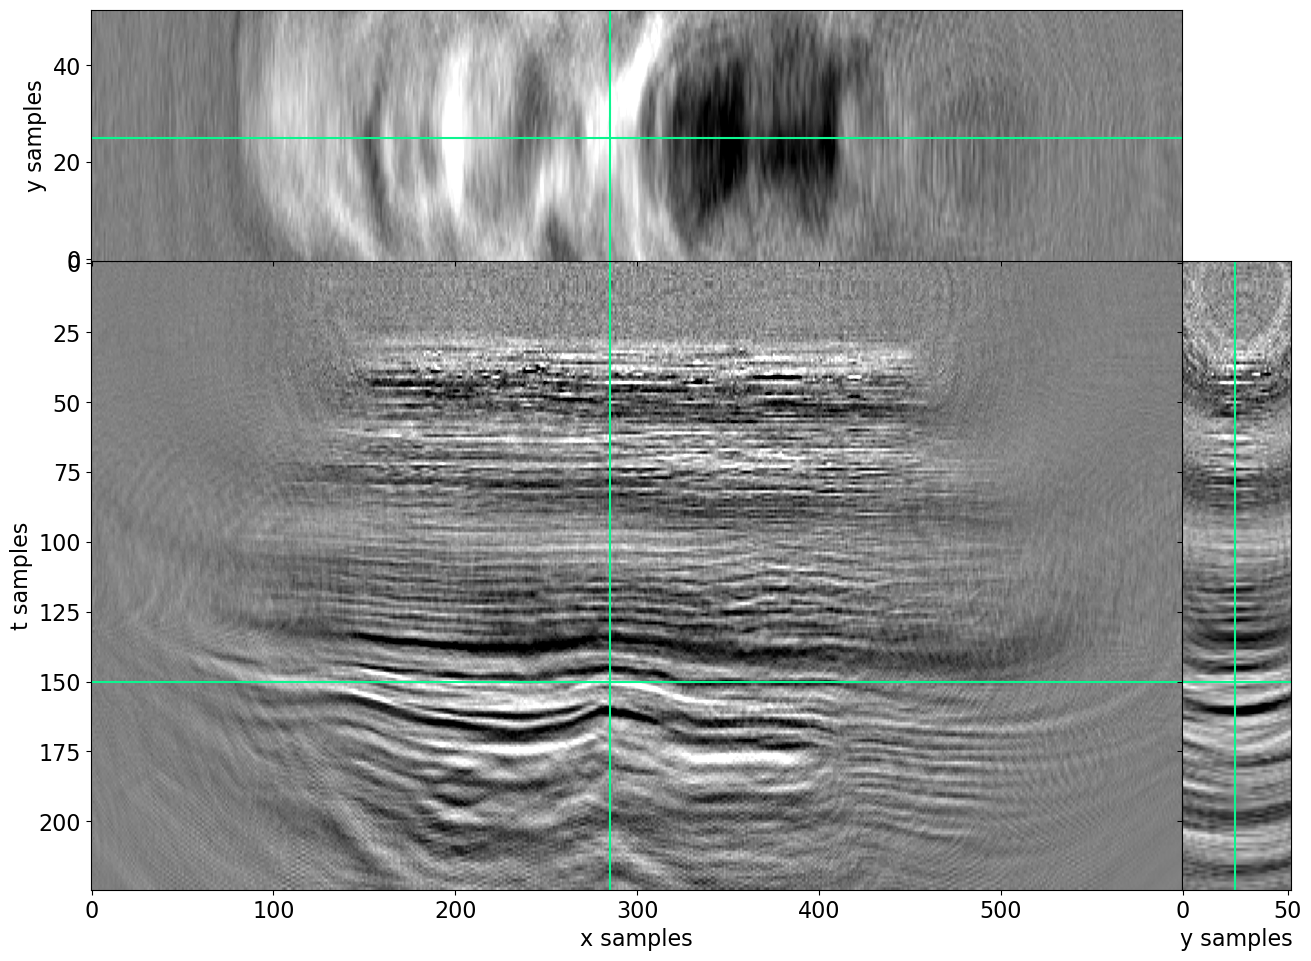

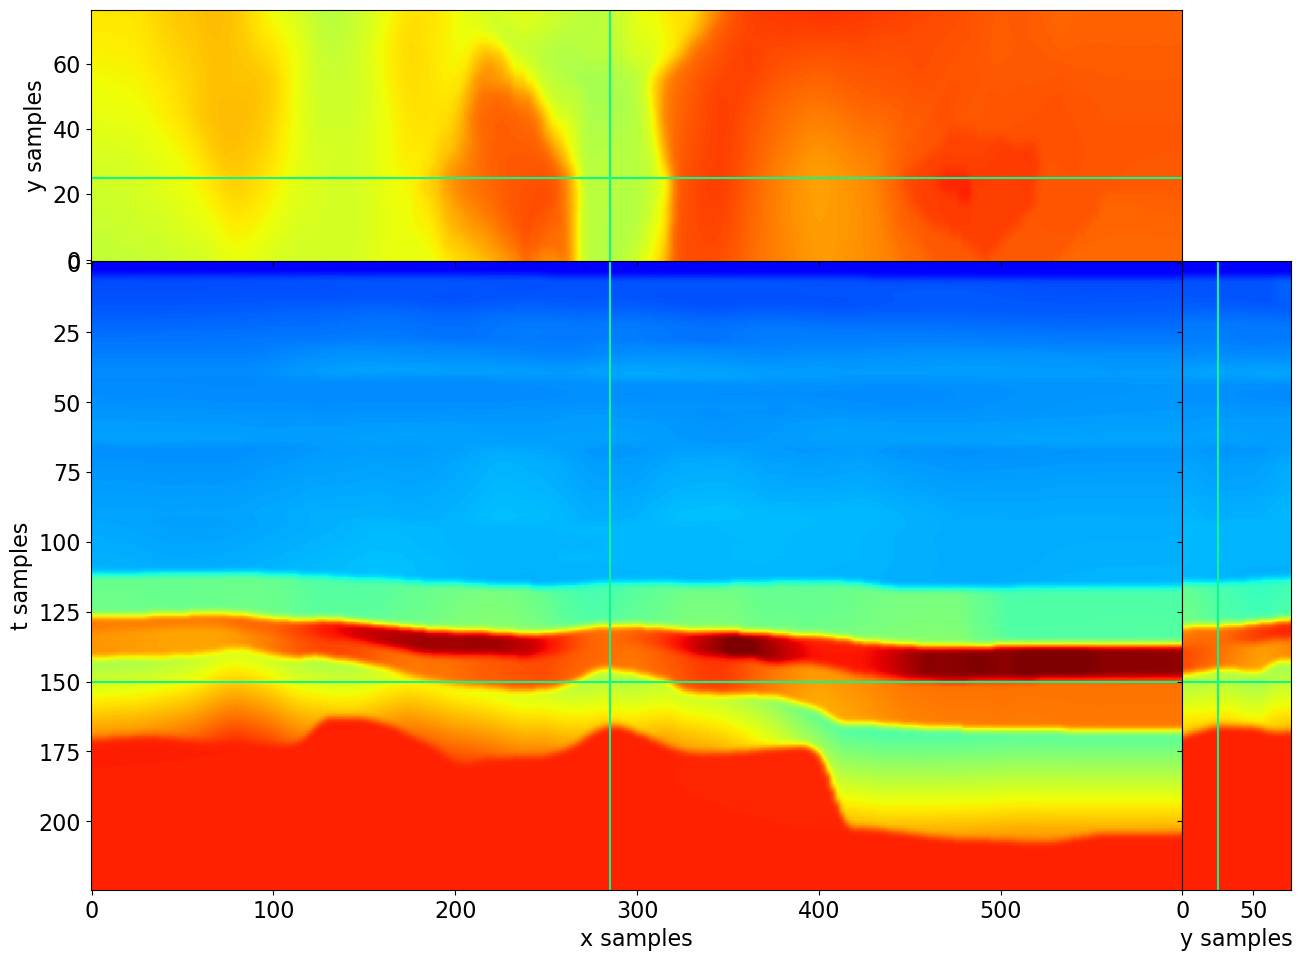

In [27]:
nshots_per_run = 300

fullimage = np.load(f'Image_sin{ishotin}_send{ishotin+nshots_per_run}.npy')
for iimage in range(1, 17):
    fullimage += np.load(f'Image_sin{ishotin + nshots * iimage}_send{ishotin + nshots * (iimage + 1)}.npy')

explode_volume(fullimage.transpose(2, 1, 0), cmap='gray', t=150, y=25, x=285, ratio=((1, 0.1), (0.4, 1)),
               clipval=(-0.2*np.abs(fullimage).max(), 0.2*np.abs(fullimage).max()), figsize=(15, 11))

explode_volume(vel_interp3d.transpose(2, 1, 0), cmap='jet', t=150, y=25, x=285, ratio=((1, 0.1), (0.4, 1)),
               clipval=(1000, 5000), figsize=(15, 11));